In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#export
from lib.nb_02 import *

https://github.com/facebookresearch/visdom

### Baseline

In [4]:
x_train, y_train, x_valid, y_valid = get_mnist()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs=64, num_workers=6)
data = Databunch(train_dl, valid_dl, c_in=784, c_out=10)

In [5]:
def get_model(data, lr=0.1):
    model = nn.Sequential(nn.Linear(data.c_in,200), nn.ReLU(), nn.Linear(200, data.c_out))
    return model, optim.SGD

In [6]:
model, opt_func = get_model(data)

In [7]:
cbfs = [partial(AvgStatsCallback,accuracy), ProgressCallback]

In [8]:
learn = Learner(model,data, F.cross_entropy, opt_func, cb_funcs=cbfs)

In [9]:
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.346794,0.735700,0.646675,0.865700,00:01
1,0.547241,0.866960,0.417208,0.895900,00:01


### Our own Optimizer

`parameter groups`: different groups can have different learning rates/momentum/weight decay... which is what lets us do discriminative learning rates.

In [10]:
#export
def compose(x, funcs, *args, order_key="_order", **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

In [11]:
class Optimizer():
    
    def __init__(self, params, steppers, **defaults):
        
        self.param_groups = list(params)
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        
        self.hypers = [{**defaults} for _ in self.param_groups]
        self.steppers = listify(steppers)
        
    
    def grad_params(self):
        return [(p,hyper) for pg,hyper in zip(self.param_groups, self.hypers)
               for p in pg if p.grad is not None]
    
    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()
    
    def step(self):
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)

In [12]:
def sgd_step(p, lr, **kwargs):
    p.data.add_(-lr, p.grad.data)
    return p

In [13]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses,self.val_losses = [],[],[]

    def after_batch(self):
        if not self.in_train: 
            self.val_losses.append(self.loss.detach().cpu())
            return 
        self.lrs.append(self.opt.hypers[-1]['lr']) ## we only plot the last param group lr, closest to output
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)
        
    def plot(self, skip_last=0):
        losses = [o.item() for o in self.losses]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(self.lrs[:n], losses[:n])

In [14]:
#export
class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs):
        self.pname,self.sched_funcs = pname,listify(sched_funcs)

    def begin_batch(self): 
        if not self.in_train: return
        fs = self.sched_funcs
        if len(fs)==1: fs = fs*len(self.opt.param_groups)
        pos = self.n_epochs/self.epochs
        for f,h in zip(fs,self.opt.hypers): h[self.pname] = f(pos)

In [15]:
#export            
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.hypers: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [16]:
opt_func = partial(Optimizer, steppers=[sgd_step])

In [17]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [18]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

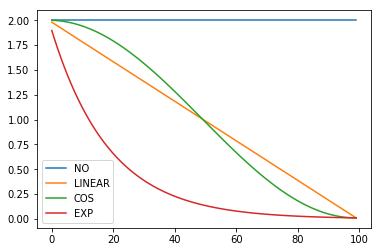

In [19]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In [20]:
model, _ = get_model(data)

sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

cbfs = [partial(AvgStatsCallback,accuracy),
        Recorder,
        partial(ParamScheduler, 'lr', sched), ProgressCallback]

learn = Learner(model,data, F.cross_entropy, opt_func, cb_funcs=cbfs)

In [21]:
learn.fit(3)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.327162,0.902360,0.402743,0.874900,00:02
1,0.118454,0.964040,0.091412,0.973800,00:02
2,0.066085,0.979860,0.076484,0.976900,00:02


In [22]:
!python3 notebook2script.py 02a_scheduler_lrfind.ipynb

Converted 02a_scheduler_lrfind.ipynb to lib/nb_02a.py
